<a href="https://colab.research.google.com/github/moemag/Speech-Emotion-Recognition/blob/main/Speech_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Libraries**

In [ ]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D, LeakyReLU
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

# **Loading the dataset**

In [ ]:
Crema = "/content/Crema/"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp /content/drive/MyDrive/archive.zip /content
!ls /content
!unzip archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: Crema/1088_IWW_FEA_XX.wav  
  inflating: Crema/1088_IWW_HAP_XX.wav  
  inflating: Crema/1088_IWW_NEU_XX.wav  
  inflating: Crema/1088_IWW_SAD_XX.wav  
  inflating: Crema/1088_MTI_ANG_XX.wav  
  inflating: Crema/1088_MTI_DIS_XX.wav  
  inflating: Crema/1088_MTI_FEA_XX.wav  
  inflating: Crema/1088_MTI_HAP_XX.wav  
  inflating: Crema/1088_MTI_NEU_XX.wav  
  inflating: Crema/1088_MTI_SAD_XX.wav  
  inflating: Crema/1088_TAI_ANG_XX.wav  
  inflating: Crema/1088_TAI_DIS_XX.wav  
  inflating: Crema/1088_TAI_FEA_XX.wav  
  inflating: Crema/1088_TAI_HAP_XX.wav  
  inflating: Crema/1088_TAI_NEU_XX.wav  
  inflating: Crema/1088_TAI_SAD_XX.wav  
  inflating: Crema/1088_TIE_ANG_XX.wav  
  inflating: Crema/1088_TIE_DIS_XX.wav  
  inflating: Crema/1088_TIE_FEA_XX.wav  
  inflating: Crema/1088_TIE_HAP_XX.wav  
  inflating: Crema/1088_TIE_NEU_XX.wav  
  inflating: Crema/1088_TIE_SAD_XX.wav  
  inflating: Crema/1088_TSI_ANG_XX.wav  
  infl

In [ ]:
crema_directory_list = os.listdir("/content/Crema/")

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')


# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()
data_path = Crema_df

**Displaying the wave plots and audio of different emotions**

In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()


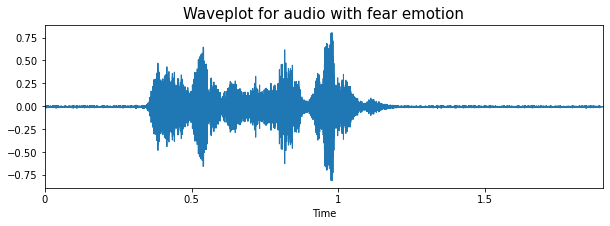

In [ ]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sample_rate = librosa.load(path)
create_waveplot(data, sample_rate, emotion)
Audio(path)


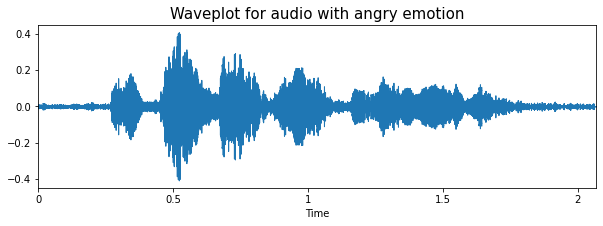

In [ ]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sample_rate = librosa.load(path)
create_waveplot(data, sample_rate, emotion)
Audio(path)

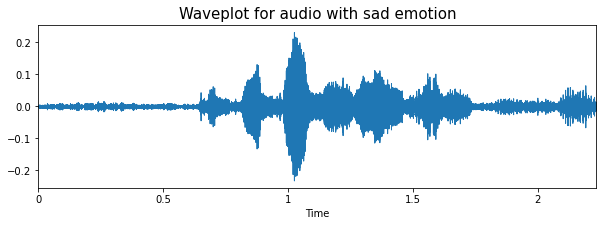

In [ ]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sample_rate = librosa.load(path)
create_waveplot(data, sample_rate, emotion)
Audio(path)

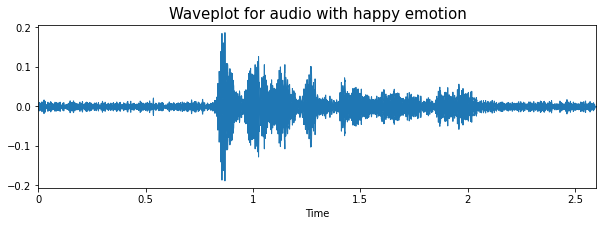

In [ ]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sample_rate = librosa.load(path)
create_waveplot(data, sample_rate, emotion)
Audio(path)

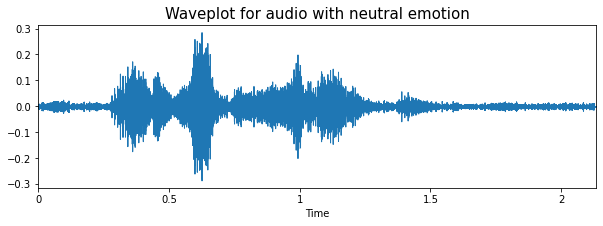

In [ ]:
emotion='neutral'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sample_rate = librosa.load(path)
create_waveplot(data, sample_rate, emotion)
Audio(path)

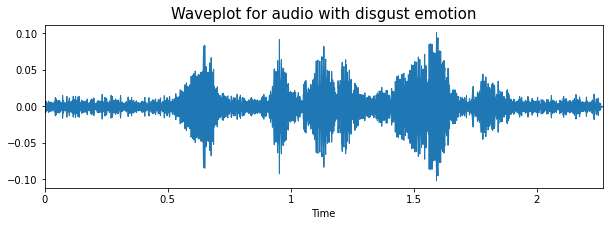

In [ ]:
emotion='disgust'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sample_rate = librosa.load(path)
create_waveplot(data, sample_rate, emotion)
Audio(path)

**Data Augmentation**

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

# **Feature Extraction**

In [ ]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally
    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    result = np.vstack((result, res1))

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically


    return result

In [ ]:
dataX, labelY = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        dataX.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        labelY.append(emotion)

In [ ]:
Features = pd.DataFrame(dataX)
Features['labels'] = labelY
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,labels
0,0.048742,0.008369,fear
1,0.048742,0.008369,fear
2,0.078419,0.008422,fear
3,0.053953,0.004006,fear
4,0.041927,0.008982,sad


In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, train_size = 0.7, random_state=0, shuffle=True)
x_val, k, y_val, l = train_test_split(x_train, y_train, test_size = 0.95, train_size = 0.05, random_state=0, shuffle=True)
#x_val.shape, k.shape, y_val.shape, l.shape


**Scaling and Adjusting dimensions**

In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_val = scaler.fit_transform(x_val)
#x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

In [ ]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_val = np.expand_dims(x_val, axis=2)
y_val = np.expand_dims(y_val, axis=2)
# y_train = np.expand_dims(y_train, axis=2)
# y_test = np.expand_dims(y_test, axis=2)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((20837, 2, 1), (20837, 6), (8931, 2, 1), (8931, 6))

# **CNN 1D Model**

In [ ]:
import tensorflow as tf

model=Sequential()
model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))

model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(6, activation='softmax'))

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=['accuracy'],
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 2, 512)            3072      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 512)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 256)            655616    
_________________________________________________________________
batch_normalization (BatchNo (None, 1, 256)            1024      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 256)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1, 128)            163968    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 1, 128)            0

In [ ]:
# import tensorflow as tf

history=model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=100,
    validation_data = (x_val, y_val))

Epoch 1/100
326/326 [==============================] - 48s 8ms/step - loss: 1.5880 - accuracy: 0.3320 - val_loss: 1.6279 - val_accuracy: 0.3641
Epoch 2/100
326/326 [==============================] - 2s 5ms/step - loss: 1.5446 - accuracy: 0.3564 - val_loss: 1.5449 - val_accuracy: 0.3343
Epoch 3/100
326/326 [==============================] - 2s 5ms/step - loss: 1.5379 - accuracy: 0.3545 - val_loss: 1.5400 - val_accuracy: 0.3554
Epoch 4/100
326/326 [==============================] - 2s 5ms/step - loss: 1.5367 - accuracy: 0.3489 - val_loss: 1.5188 - val_accuracy: 0.3775
Epoch 5/100
326/326 [==============================] - 2s 5ms/step - loss: 1.5325 - accuracy: 0.3578 - val_loss: 1.5412 - val_accuracy: 0.3842
Epoch 6/100
326/326 [==============================] - 2s 5ms/step - loss: 1.5388 - accuracy: 0.3488 - val_loss: 1.5367 - val_accuracy: 0.3333
Epoch 7/100
326/326 [==============================] - 2s 6ms/step - loss: 1.5256 - accuracy: 0.3636 - val_loss: 1.5175 - val_accuracy: 0.373

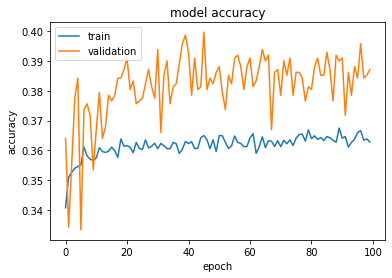

In [ ]:
#Plot model accuracy over ephocs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)

In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,neutral,happy
1,sad,sad
2,happy,happy
3,sad,disgust
4,sad,fear
5,disgust,fear
6,neutral,sad
7,happy,neutral
8,angry,angry
9,angry,angry


# **Evaluation**

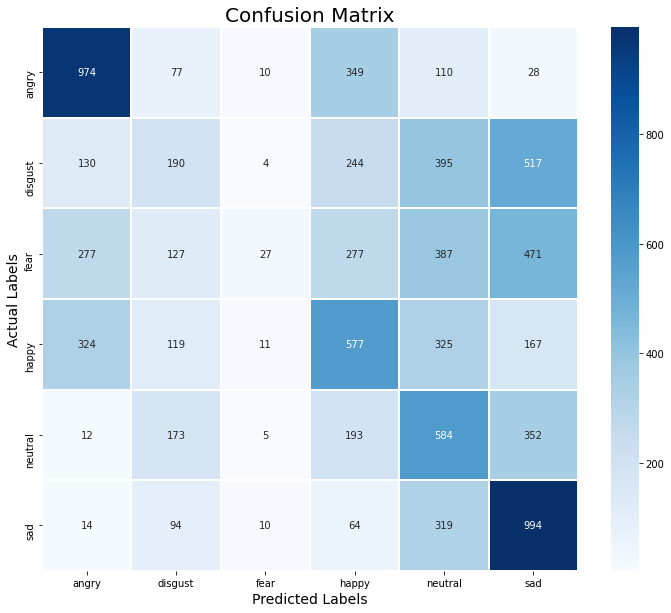

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.56      0.63      0.59      1548
     disgust       0.24      0.13      0.17      1480
        fear       0.40      0.02      0.03      1566
       happy       0.34      0.38      0.36      1523
     neutral       0.28      0.44      0.34      1319
         sad       0.39      0.66      0.49      1495

    accuracy                           0.37      8931
   macro avg       0.37      0.38      0.33      8931
weighted avg       0.37      0.37      0.33      8931



# **CNN 2 Model**

In [ ]:
def extract_features_2(data):
    aloo = []
    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    # aloo = np.hstack((aloo, mel)) # stacking horizontally

    return mel

def get_features_2(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features_2(data)
    aloo = np.array(res1)
    aloo = np.vstack((aloo, res1))

    return aloo

In [ ]:
dataX, labelY = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features_2(path)
    for ele in feature:
        dataX.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        labelY.append(emotion)


In [ ]:
Features = pd.DataFrame(dataX)
Features['labels'] = labelY
Features.to_csv('features.csv', index=False)
Features.head()
#Features.shape

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,labels
0,0.056752,0.032461,0.050758,0.077574,0.041742,0.057209,0.184948,0.221592,0.168005,0.054500,0.037246,0.020173,0.078067,0.204629,0.215830,0.302850,0.164365,0.018911,0.005194,0.007005,0.008039,0.023885,0.037103,0.030284,0.054238,0.040509,0.007464,0.002868,0.005434,0.006424,0.017406,0.052403,0.040690,0.005394,0.004953,0.004337,0.001148,0.001179,0.010974,0.017903,...,0.000076,0.000104,0.000117,0.000141,0.000150,0.000136,0.000165,0.000086,0.000057,0.000054,0.000052,0.000064,0.000061,0.000063,0.000064,0.000090,0.000081,0.000103,0.000101,0.000110,0.000081,0.000070,0.000063,0.000049,0.000036,0.000010,7.522241e-07,6.439887e-09,6.769835e-10,5.464136e-10,4.585798e-10,3.962670e-10,3.512809e-10,3.175588e-10,2.920852e-10,2.731296e-10,2.591459e-10,2.496468e-10,2.438914e-10,fear
1,0.056752,0.032461,0.050758,0.077574,0.041742,0.057209,0.184948,0.221592,0.168005,0.054500,0.037246,0.020173,0.078067,0.204629,0.215830,0.302850,0.164365,0.018911,0.005194,0.007005,0.008039,0.023885,0.037103,0.030284,0.054238,0.040509,0.007464,0.002868,0.005434,0.006424,0.017406,0.052403,0.040690,0.005394,0.004953,0.004337,0.001148,0.001179,0.010974,0.017903,...,0.000076,0.000104,0.000117,0.000141,0.000150,0.000136,0.000165,0.000086,0.000057,0.000054,0.000052,0.000064,0.000061,0.000063,0.000064,0.000090,0.000081,0.000103,0.000101,0.000110,0.000081,0.000070,0.000063,0.000049,0.000036,0.000010,7.522241e-07,6.439887e-09,6.769835e-10,5.464136e-10,4.585798e-10,3.962670e-10,3.512809e-10,3.175588e-10,2.920852e-10,2.731296e-10,2.591459e-10,2.496468e-10,2.438914e-10,fear
2,0.046644,0.033839,0.070904,0.199856,0.107668,0.118111,0.068685,0.212748,0.785010,0.200721,0.045365,0.077504,0.132016,0.041652,0.080970,0.078289,0.029409,0.033853,0.040475,0.102753,0.196817,0.048108,0.022327,0.070243,0.888966,0.468832,0.009989,0.006106,0.013760,0.023179,0.005411,0.001685,0.005532,0.006592,0.002966,0.002271,0.003555,0.003701,0.002824,0.001919,...,0.000052,0.000057,0.000044,0.000053,0.000040,0.000049,0.000071,0.000038,0.000038,0.000034,0.000030,0.000033,0.000028,0.000025,0.000025,0.000028,0.000025,0.000033,0.000032,0.000034,0.000036,0.000032,0.000053,0.000054,0.000026,0.000012,6.414920e-07,2.690211e-09,2.402246e-10,3.829098e-10,4.755860e-10,5.322153e-10,5.664724e-10,5.857436e-10,5.956567e-10,6.003752e-10,6.017528e-10,6.019982e-10,6.014085e-10,sad
3,0.046644,0.033839,0.070904,0.199856,0.107668,0.118111,0.068685,0.212748,0.785010,0.200721,0.045365,0.077504,0.132016,0.041652,0.080970,0.078289,0.029409,0.033853,0.040475,0.102753,0.196817,0.048108,0.022327,0.070243,0.888966,0.468832,0.009989,0.006106,0.013760,0.023179,0.005411,0.001685,0.005532,0.006592,0.002966,0.002271,0.003555,0.003701,0.002824,0.001919,...,0.000052,0.000057,0.000044,0.000053,0.000040,0.000049,0.000071,0.000038,0.000038,0.000034,0.000030,0.000033,0.000028,0.000025,0.000025,0.000028,0.000025,0.000033,0.000032,0.000034,0.000036,0.000032,0.000053,0.000054,0.000026,0.000012,6.414920e-07,2.690211e-09,2.402246e-10,3.829098e-10,4.755860e-10,5.322153e-10,5.664724e-10,5.857436e-10,5.956567e-10,6.003752e-10,6.017528e-10,6.019982e-10,6.014085e-10,sad
4,0.067110,0.046070,0.052383,0.069056,0.069050,0.087249,0.118071,0.471652,0.690038,0.630446,1.886965,4.700452,12.442020,4.855011,2.206996,2.284559,0.246401,0.059878,0.086420,0.979897,5.496545,3.546932,0.534126,0.207146,0.751126,4.085865,5.742979,6.152466,8.636030,15.257396,33.882492,9.716183,1.965955,0.223363,0.194206,0.479091,1.825083,1.932137,4.087309,13.004925,...,0.021142,0.077724,0.040574,0.009766,0.009585,0.009348,0.020174,0.010842,0.008555,0.009653,0.007912,0.005512,0.004481,0.004764,0.001846,0.004636,0.002548,0.002139,0.002574,0.001666,0.002923,0.002191,0.003667,0.002495,0.001933,0.000472,1.465409e-05,3.742986e-07,2.937890e

In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, train_size = 0.7, random_state=0, shuffle=True)
k, x_val, l, y_val = train_test_split(x_train, y_train, train_size = 0.95, test_size = 0.05, random_state=0, shuffle=True)
x_train =  np.array(x_train).reshape(-1,128,1,1)

x_test =  np.array(x_test).reshape(-1,128,1,1)

x_val =  np.array(x_val).reshape(-1,128,1,1)

y_val = np.expand_dims(y_val, axis=2)
y_val = np.expand_dims(y_val, axis=3)

y_train = np.expand_dims(y_train, axis=2)
y_train = np.expand_dims(y_train, axis=3)

y_test = np.expand_dims(y_test, axis=2)
y_test = np.expand_dims(y_test, axis=3)

x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((10418, 128, 1, 1),
 (10418, 6, 1, 1),
 (4466, 128, 1, 1),
 (4466, 6, 1, 1),
 (521, 128, 1, 1),
 (521, 6, 1, 1))

In [ ]:
import tensorflow as tf

model=Sequential()
model.add(Conv2D(512, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[0], x_train.shape[1], 1)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=5, strides = 2, padding = 'same'))


model.add(Conv2D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv2D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv2D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=5, strides = 3, padding = 'same'))


model.add(Dropout(0.5))
# model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer=tf.keras.optimizers.Adam( learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=['accuracy'],
)
model.summary()



Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 10418, 128, 512)   13312     
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 10418, 128, 512)   0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 5209, 64, 512)     0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 5209, 64, 256)     3277056   
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 5209, 64, 256)     0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 2605, 32, 256)     0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 2605, 32, 128)    

In [ ]:

history=model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=10,
    validation_data = (x_val, y_val))

Epoch 1/10
163/163 [==============================] - 8s 40ms/step - loss: 0.0000e+00 - accuracy: 0.8124 - val_loss: 0.0000e+00 - val_accuracy: 0.8333
Epoch 2/10
163/163 [==============================] - 6s 37ms/step - loss: 0.0000e+00 - accuracy: 0.8333 - val_loss: 0.0000e+00 - val_accuracy: 0.8333
Epoch 3/10
163/163 [==============================] - 6s 37ms/step - loss: 0.0000e+00 - accuracy: 0.8333 - val_loss: 0.0000e+00 - val_accuracy: 0.8333
Epoch 4/10
163/163 [==============================] - 6s 37ms/step - loss: 0.0000e+00 - accuracy: 0.8333 - val_loss: 0.0000e+00 - val_accuracy: 0.8333
Epoch 5/10
163/163 [==============================] - 6s 38ms/step - loss: 0.0000e+00 - accuracy: 0.8333 - val_loss: 0.0000e+00 - val_accuracy: 0.8333
Epoch 6/10
163/163 [==============================] - 6s 37ms/step - loss: 0.0000e+00 - accuracy: 0.8333 - val_loss: 0.0000e+00 - val_accuracy: 0.8333
Epoch 7/10
163/163 [==============================] - 6s 37ms/step - loss: 0.0000e+00 - accura

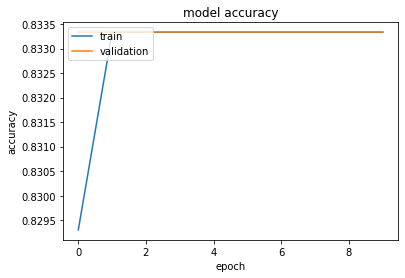

In [ ]:
#Plot model accuracy over ephocs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# predicting on test data.
pred_test = model.predict(x_test)
pred_test=pred_test.reshape(4466,6)
y_test=y_test.reshape(4466,6)
print(y_test.shape)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)

(4466, 6)


In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,angry,neutral
1,angry,angry
2,angry,neutral
3,angry,angry
4,angry,disgust
5,angry,sad
6,angry,angry
7,angry,disgust
8,angry,sad
9,angry,fear


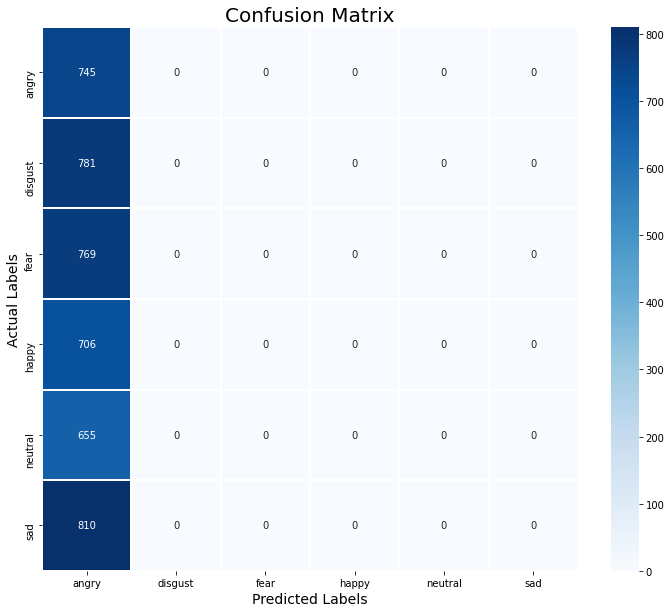

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.17      1.00      0.29       745
     disgust       0.00      0.00      0.00       781
        fear       0.00      0.00      0.00       769
       happy       0.00      0.00      0.00       706
     neutral       0.00      0.00      0.00       655
         sad       0.00      0.00      0.00       810

    accuracy                           0.17      4466
   macro avg       0.03      0.17      0.05      4466
weighted avg       0.03      0.17      0.05      4466



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
